*GoogleDrive Mounting*

---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Data Fetching*

---



In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import librosa

base_dir = '/content/drive/MyDrive/Colab Notebooks/Pattern Recognition/Final Project/Dataset'

honks_dir = os.path.join(base_dir, 'Honks')
non_honks_dir = os.path.join(base_dir, 'Non-Honks')

print(len(honks_dir))
print(len(non_honks_dir))

86
90


*Feature Extraction*

---



In [7]:
dfs = []
genres = {'Honks': 0, 'Non-Honks': 1}

# Iterate over each genre and file to populate the DataFrame
for genre, genre_number in genres.items():
    directory = os.path.join(base_dir, genre)
    genre_data = []
    for filename in os.listdir(directory):
        files = os.path.join(directory, filename)
        for index in range(14):
            y, sr = librosa.load(files, mono=True, duration=2)
            ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=512, n_fft=512, n_mels=64)
            ps = librosa.power_to_db(ps**2)
            genre_data.append({'spectrogram': ps, 'type': genre_number})
    genre_df = pd.DataFrame(genre_data)
    dfs.append(genre_df)

# Concatenate the DataFrames
df = pd.concat(dfs, ignore_index=True)

print(df.shape)
print(df.head())

(15120, 2)
                                         spectrogram  type
0  [[-35.326603, -30.97872, -27.9755, -36.716133,...     0
1  [[-35.326603, -30.97872, -27.9755, -36.716133,...     0
2  [[-35.326603, -30.97872, -27.9755, -36.716133,...     0
3  [[-35.326603, -30.97872, -27.9755, -36.716133,...     0
4  [[-35.326603, -30.97872, -27.9755, -36.716133,...     0


*Spectrogram Visualization*

---



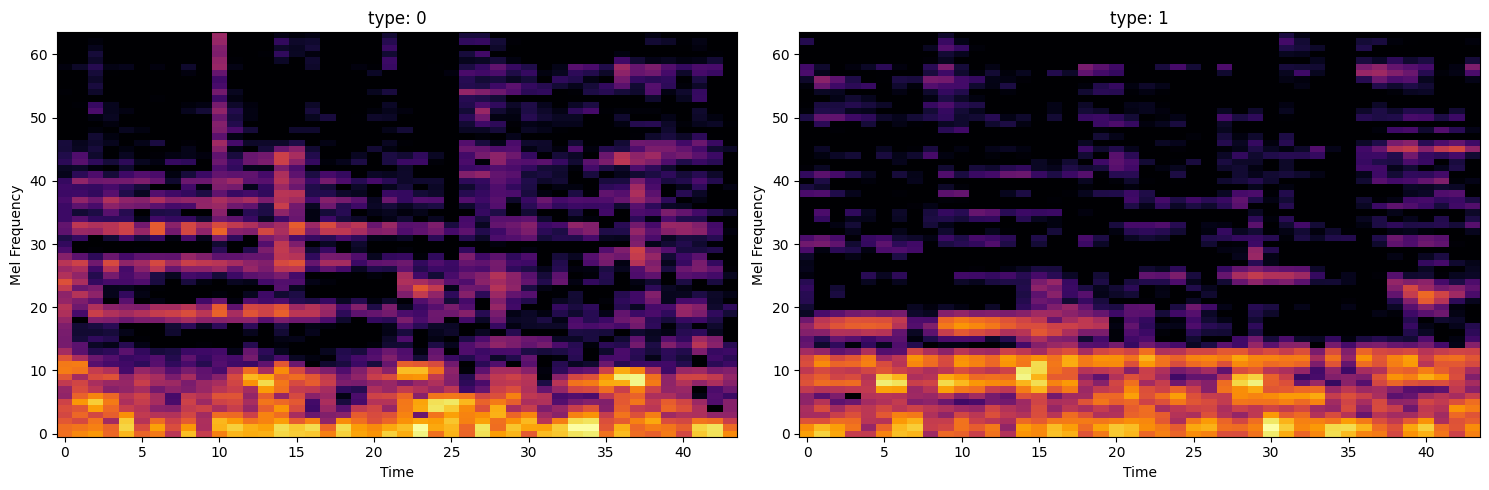

In [8]:
# Create a figure and axis for subplots
fig, axs = plt.subplots(1, len(df['type'].unique()), figsize=(15, 5))

# Visualize one sample from each type
for i, type_number in enumerate(df['type'].unique()):
    type_df = df[df['type'] == type_number]
    sample_ps_data = type_df.iloc[0]['spectrogram']  # Take the first sample for each type
    ax = axs[i]
    ax.imshow(sample_ps_data, aspect='auto', origin='lower', cmap='inferno')
    ax.set_title(f'type: {type_number}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Mel Frequency')
    # ax.colorbar(label='Power (dB)')

plt.tight_layout()
plt.show()


In [9]:
a = df['spectrogram'].iloc[1]
a.shape

(64, 44)

In [10]:
shuffled_df = df.sample(frac = 1, random_state = 42)
shuffled_df

,spectrogram,type
6077,"[[-43.652176, -28.799953, -38.07595, -30.72825...",0
7894,"[[-100.0, -100.0, -100.0, -100.0, -100.0, -100...",1
6820,"[[-78.55067, -63.928524, -73.35092, -62.06225,...",0
1593,"[[-37.54543, -61.03488, -53.7973, -56.846474, ...",0
11986,"[[-78.4429, -72.1494, -66.46661, -70.6703, -84...",1
...,...,...
5191,"[[-85.98781, -99.81801, -77.638985, -83.2516, ...",0
13418,"[[-16.573215, -1.5117764, 8.070341, 6.4171085,...",1
5390,"[[-29.244507, -33.087803, -41.390167, -66.5879...",0
860,"[[-36.040554, -31.816402, -44.38757, -40.14513...",0


*Train Test Split*

---



In [11]:
from sklearn.model_selection import train_test_split

# perform three-way split to train, val, test
x = shuffled_df['spectrogram']
y = shuffled_df['type']

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size = 0.1, random_state = 123)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 0.4, random_state = 123)

x_train = np.array([np.expand_dims(x, axis=-1) for x in x_train])
x_val = np.array([np.expand_dims(x, axis=-1) for x in x_val])
x_test = np.array([np.expand_dims(x, axis=-1) for x in x_test])

# Repeat the single channel to create three channels
x_train = np.repeat(x_train, 3, axis=-1)
x_val = np.repeat(x_val, 3, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)

print(f'train data: {x_train.shape}, train label: {y_train.shape}')
print(f'val data {x_val.shape}, val label: {y_val.shape}')
print(f'test data {x_test.shape}, test label {y_test.shape}')

print(x_train[0].shape)
print(x_val[0].shape)
print(x_test[0].shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

train data: (13608, 64, 44, 3), train label: (13608,)
val data (907, 64, 44, 3), val label: (907,)
test data (605, 64, 44, 3), test label (605,)
(64, 44, 3)
(64, 44, 3)
(64, 44, 3)
(13608,)
(907,)
(605,)


In [22]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

print(y_train.shape, y_val.shape, y_test.shape)

(13608, 2) (907, 2) (605, 2)


*Model Development*

---



In [13]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

# load ResNet50 Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 44, 3), pooling='max')

for layer in base_model.layers:
    layer.trainable = False


94765736/94765736 [==============================] - 1s 0us/step


In [14]:
# model's architecture
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential

model = Sequential([
    base_model,
    BatchNormalization(),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24646018 (94.02 MB)
Trainable params: 1054210 (4.02 MB)
Non-trainable params: 23591808 (90.00 MB)
__________

In [15]:
from tensorflow.keras.applications import VGG16

# load VGG16 Model
VGG16_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 44, 3), pooling='max')

for layer in VGG16_base_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [16]:
vgg_model = Sequential([
    VGG16_base_model,
    BatchNormalization(),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dense(2, activation='softmax')
])

vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 14980418 (57.15 MB)
Trainable params: 264706 (1.01 MB)
Non-trainable params: 14715712 (56.14 MB)
_________

In [23]:
# compiling the model
model.compile(
    loss ='categorical_crossentropy',
    optimizer = tf.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

vgg_model.compile(
    loss ='categorical_crossentropy',
    optimizer = tf.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

*Model Training*

---



In [24]:
vgg_hist = vgg_model.fit(
      x_train, y_train,
      epochs = 15,
      validation_data = (x_val, y_val),
      batch_size = 32,
      # validation_steps= 27,
      verbose = 1,
      # callbacks = [callbacks]
)

Epoch 1/15
426/426 [==============================] - 13s 18ms/step - loss: 0.1291 - accuracy: 0.9515 - val_loss: 0.0271 - val_accuracy: 0.9934
Epoch 2/15
426/426 [==============================] - 6s 14ms/step - loss: 0.0252 - accuracy: 0.9933 - val_loss: 0.0439 - val_accuracy: 0.9879
Epoch 3/15
426/426 [==============================] - 6s 14ms/step - loss: 0.0260 - accuracy: 0.9911 - val_loss: 0.0382 - val_accuracy: 0.9901
Epoch 4/15
426/426 [==============================] - 6s 15ms/step - loss: 0.0177 - accuracy: 0.9943 - val_loss: 0.1526 - val_accuracy: 0.9945
Epoch 5/15
426/426 [==============================] - 6s 14ms/step - loss: 0.0113 - accuracy: 0.9961 - val_loss: 0.1569 - val_accuracy: 0.9956
Epoch 6/15
426/426 [==============================] - 6s 15ms/step - loss: 0.0165 - accuracy: 0.9948 - val_loss: 0.0822 - val_accuracy: 0.9978
Epoch 7/15
426/426 [==============================] - 7s 17ms/step - loss: 0.0206 - accuracy: 0.9943 - val_loss: 0.1648 - val_accuracy: 0.993

In [25]:
model_hist = model.fit(
      x_train, y_train,
      epochs = 15,
      validation_data = (x_val, y_val),
      batch_size = 32,
      # validation_steps= 27,
      verbose = 1,
      # callbacks = [callbacks]
)

Epoch 1/15
426/426 [==============================] - 15s 21ms/step - loss: 0.1080 - accuracy: 0.9664 - val_loss: 0.0089 - val_accuracy: 0.9978
Epoch 2/15
426/426 [==============================] - 7s 16ms/step - loss: 0.0190 - accuracy: 0.9939 - val_loss: 0.0079 - val_accuracy: 0.9967
Epoch 3/15
426/426 [==============================] - 7s 16ms/step - loss: 0.0424 - accuracy: 0.9888 - val_loss: 0.0092 - val_accuracy: 0.9978
Epoch 4/15
426/426 [==============================] - 8s 18ms/step - loss: 0.0077 - accuracy: 0.9984 - val_loss: 1.0802e-04 - val_accuracy: 1.0000
Epoch 5/15
426/426 [==============================] - 7s 16ms/step - loss: 0.0079 - accuracy: 0.9981 - val_loss: 3.1124e-04 - val_accuracy: 1.0000
Epoch 6/15
426/426 [==============================] - 8s 18ms/step - loss: 0.0075 - accuracy: 0.9989 - val_loss: 0.0035 - val_accuracy: 0.9978
Epoch 7/15
426/426 [==============================] - 7s 16ms/step - loss: 0.0260 - accuracy: 0.9936 - val_loss: 0.0022 - val_accurac

*Model Training History*

---



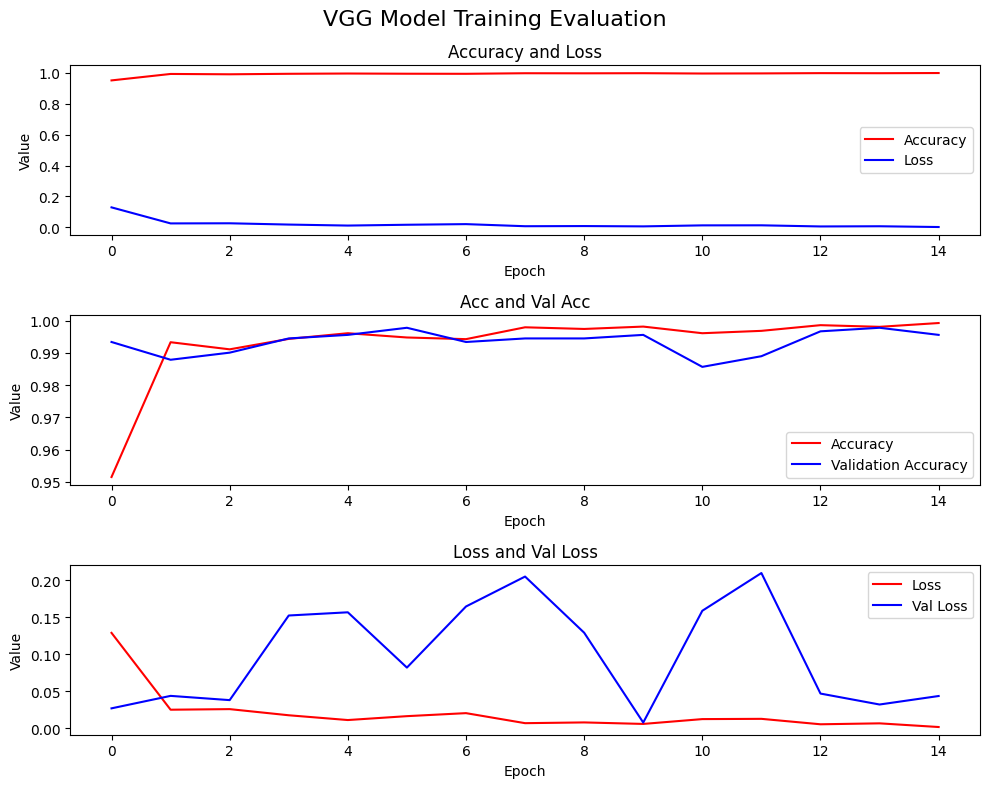

In [40]:
accuracy = vgg_hist.history['accuracy']
validation_accuracy = vgg_hist.history['val_accuracy']
loss = vgg_hist.history['loss']
validation_loss = vgg_hist.history['val_loss']

fig, ax = plt.subplots(nrows = 3, figsize = (10, 8))

ax[0].plot(accuracy, 'r', label='Accuracy')
ax[0].plot(loss, 'b', label='Loss')
ax[0].set_title('Accuracy and Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Value')
ax[0].legend(loc = 0)

ax[1].plot(accuracy, 'r', label='Accuracy')
ax[1].plot(validation_accuracy, 'b', label='Validation Accuracy')
ax[1].set_title('Acc and Val Acc')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Value')
ax[1].legend(loc = 0)

ax[2].plot(loss, 'r', label='Loss')
ax[2].plot(validation_loss, 'b', label='Val Loss')
ax[2].set_title('Loss and Val Loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Value')
ax[2].legend(loc = 0)

fig.suptitle('VGG Model Training Evaluation', fontsize=16)

plt.tight_layout()
plt.show()

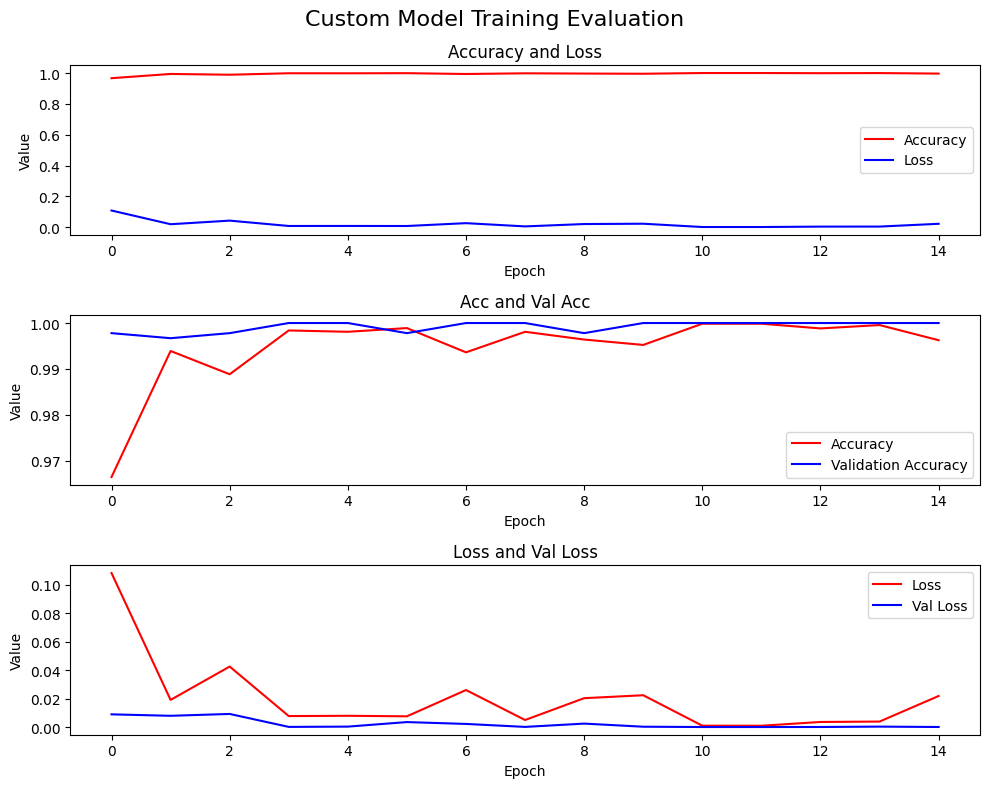

In [41]:
accuracy = model_hist.history['accuracy']
validation_accuracy = model_hist.history['val_accuracy']
loss = model_hist.history['loss']
validation_loss = model_hist.history['val_loss']

fig, ax = plt.subplots(nrows = 3, figsize = (10, 8))

ax[0].plot(accuracy, 'r', label='Accuracy')
ax[0].plot(loss, 'b', label='Loss')
ax[0].set_title('Accuracy and Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Value')
ax[0].legend(loc = 0)

ax[1].plot(accuracy, 'r', label='Accuracy')
ax[1].plot(validation_accuracy, 'b', label='Validation Accuracy')
ax[1].set_title('Acc and Val Acc')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Value')
ax[1].legend(loc = 0)

ax[2].plot(loss, 'r', label='Loss')
ax[2].plot(validation_loss, 'b', label='Val Loss')
ax[2].set_title('Loss and Val Loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Value')
ax[2].legend(loc = 0)

fig.suptitle('Custom Model Training Evaluation', fontsize=16)

plt.tight_layout()
plt.show()

*Model Testing*

---



In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = pd.DataFrame(
    columns = ['model', 'VGG'],
    index = ['acc', 'prec', 'rec', 'f1']
)

def test(classifier, x, y, dataframe, model_name):
    # classifier.fit(x, y)
    pred = classifier.predict(x)

    # Convert one-hot encoded y to single class labels
    y_single_class = np.argmax(y, axis = 1)
    pred_single_class = np.argmax(pred, axis = 1)

    acc = accuracy_score(y_true = y_single_class, y_pred = pred_single_class)
    prec = precision_score(y_true = y_single_class, y_pred = pred_single_class, average = 'weighted')
    rec = recall_score(y_true = y_single_class, y_pred = pred_single_class, average = 'weighted')
    f1 = f1_score(y_true = y_single_class, y_pred = pred_single_class, average = 'weighted')

    dataframe.loc['acc', model_name] = acc
    dataframe.loc['prec', model_name] = prec
    dataframe.loc['rec', model_name] = rec
    dataframe.loc['f1', model_name] = f1

    return pred, dataframe

model_pred, model_res = test(model, x_test, y_test, results, 'model')
model_res

19/19 [==============================] - 2s 58ms/step


,model,VGG
acc,1.0,NaN
prec,1.0,NaN
rec,1.0,NaN
f1,1.0,NaN


In [32]:
vgg_pred, vgg_res = test(vgg_model, x_test, y_test, results, 'VGG')
vgg_res

19/19 [==============================] - 1s 62ms/step


,model,VGG
acc,1.0,0.996694
prec,1.0,0.996715
rec,1.0,0.996694
f1,1.0,0.996694


In [33]:
model_pred

array([[1.0000000e+00, 0.0000000e+00],
       [9.9999988e-01, 6.4428065e-08],
       [1.0000000e+00, 0.0000000e+00],
       ...,
       [1.9900423e-08, 1.0000000e+00],
       [3.6055762e-31, 1.0000000e+00],
       [1.0000000e+00, 8.2129183e-09]], dtype=float32)

In [35]:
model_labels = np.argmax(model_pred, axis=1)

print(len(model_labels))
model_labels

605


array([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,

In [36]:
y_test_labels = np.argmax(y_test, axis=1)

print(y_test_labels)

[0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 1 0 1 1 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0
 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1
 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1
 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 0 1 1
 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 1 0 1 0 0 1
 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 0
 1 0 1 1 1 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1
 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1
 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1
 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1
 0 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 0
 1 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0
 1 1 0 0 0 1 1 1 1 0 0 0 

In [37]:
vgg_labels = np.argmax(vgg_pred, axis=1)

print(len(vgg_labels))
vgg_labels

605


array([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,

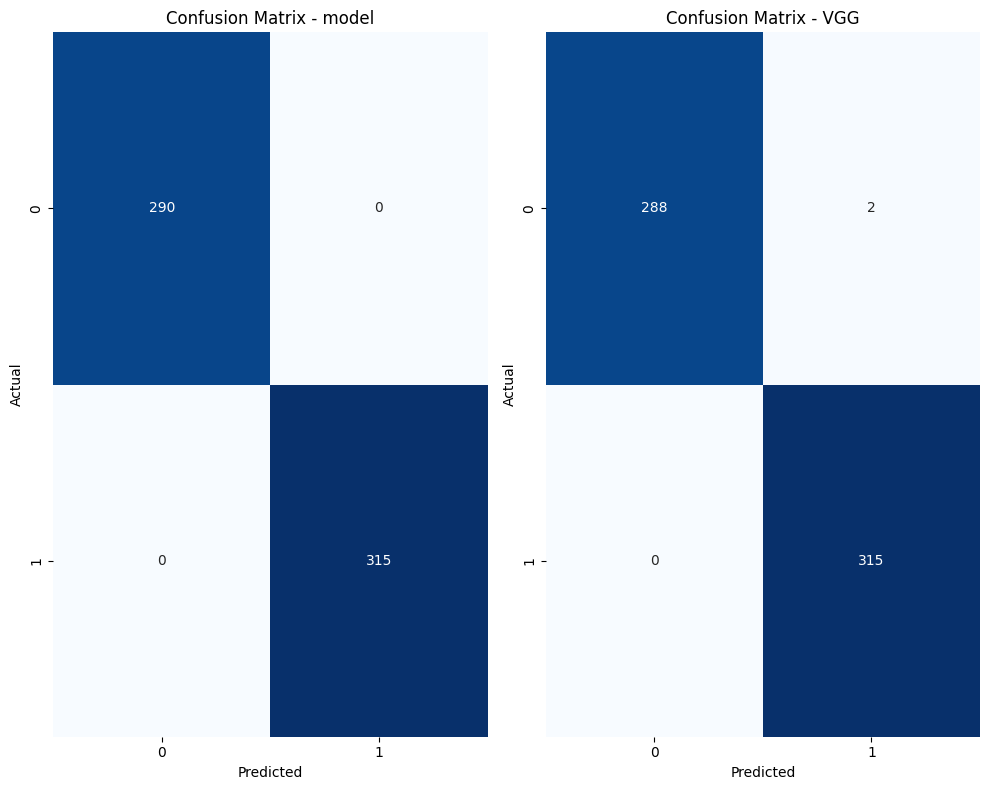

In [38]:
from sklearn.metrics import confusion_matrix

# confusion matrix builder
def plot_confusion_matrix(model_name, y_true, y_pred, ax):
    # model_pred_labels = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False, ax = ax)
    ax.set_title(f'Confusion Matrix - {model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')


# show the confusion matrix
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 8))

plot_confusion_matrix('model', y_test_labels, model_labels, ax[0])
plot_confusion_matrix('VGG', y_test_labels, vgg_labels, ax[1])

plt.tight_layout()
plt.show()

In [39]:
# fetch 10 samples
sample_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# dictionary
data_dict = {
    'y_true': y_test_labels[sample_indices],
    'model_prediction': model_labels[sample_indices],
    'vgg_prediction': vgg_labels[sample_indices]
}

# put in dataframe
labels_df = pd.DataFrame(data_dict)

# display the dataframe
labels_df

,y_true,model_prediction,vgg_prediction
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
5,0,0,0
6,1,1,1
7,1,1,1
8,0,0,0
9,1,1,1
